# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры и проверим её на тестовой выборке.

Дополнительно измерим *AUC-ROC*, сравним её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

Для начала импортируем все необходимые библиотеки и метрики качества

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
data = pd.read_csv('/datasets/Churn.csv')

Отдельно для наглядности выведем названия стобцов с признаками и целевой признак

> #### Признаки
RowNumber — индекс строки в данных<br>
CustomerId — уникальный идентификатор клиента<br>
Surname — фамилия
CreditScore — кредитный рейтинг<br>
Geography — страна проживания
Gender — пол<br>
Age — возраст
Tenure — количество недвижимости у клиента<br>
Balance — баланс на счёте
NumOfProducts — количество продуктов банка, используемых клиентом<br>
HasCrCard — наличие кредитной карты
IsActiveMember — активность клиента<br>
EstimatedSalary — предполагаемая зарплата
>#### Целевой признак
Exited — факт ухода клиента<br>

Выведем на экран первые 5 строчек таблицы и информацию о ней, поймем что дальше делать

In [116]:
display(data.head())
data.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


>Вывод: датафрейм имеет 3 колонки с типом object: <br> 
>>'Geography' (страна получения кредита) - с помощью техники OHE заменим на дамми-данные<br> 
>>'Gender'(пол) - с помощью техники OHE заменим на дамми-данные<br> 
>>'Surname'(фамилия)- можно не учитывать при подготовке модели , не является значимым признаком<br>

>В колонке 'Tenure' (количество недвижимости у клиента) имеются объекты nan, их заменим на 0

In [117]:
data['Geography'] = pd.get_dummies(data['Geography'], drop_first=True)
data['Gender'] = pd.get_dummies(data['Gender'], drop_first=True)
data['Tenure'].fillna(0, inplace = True)

Определим колонки с признаками и колонки с целевым признаком<br>
Разобьем данные на обучающую(60%), валидационную(20%) и тестовую(20%) выборки

In [118]:
target  = data['Exited']
features = data.drop(['Surname','Exited','RowNumber','CustomerId'], axis = 1)
features_train,features_pretest, target_train,target_pretest = \
    train_test_split(features, target, test_size = 0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = \
    train_test_split(features_pretest, target_pretest, test_size = 0.5, random_state = 12345)

# 2. Исследование задачи

Введем 3 модели: LogisticRegression, DecisionTreeClassifier и RandomForestClassifier, также ради интереса 4ю условную модель, предсказывающее всегда одно и то же значение "1"<br>
На данном этапе дисбаланс значений обрабатывать не будем

In [119]:
model = LogisticRegression(random_state = 12345, solver = 'liblinear')
model.fit(features_train, target_train)
predict_linear_regression = model.predict(features_valid)
print('Для модели логистической регрессии, без обработки дисбаланса, будет следующее значение f1 меры: ',\
        f1_score(target_valid,predict_linear_regression))

print()
model = DecisionTreeClassifier(random_state = 12345, max_depth = 5)
model.fit(features_train, target_train)
predict_decision_tree = model.predict(features_valid)
print('Для модели дерева решений, без обработки дисбаланса, будет следующее значение f1 меры: ',\
        f1_score(target_valid,predict_decision_tree))

print()
model = RandomForestClassifier(random_state = 12345, n_estimators = 27, max_depth = 8)
model.fit(features_train, target_train)
predict_random_forest = model.predict(features_valid)
print('Для модели леса деревьев, без обработки дисбаланса, будет следующее значение f1 меры: ',\
        f1_score(target_valid,predict_random_forest))

print()
#Сравним cо значением f1 простейшей модели, предсказывающей всегда "1"
dummy_model = pd.Series(1,index = target_valid)
print('Для простейшей модели, всегда предсказывающей ответ 1, будет следующее значение f1 меры: ',\
        f1_score(target_valid,dummy_model))


Для модели логистической регрессии, без обработки дисбаланса, будет следующее значение f1 меры:  0.08385744234800838

Для модели дерева решений, без обработки дисбаланса, будет следующее значение f1 меры:  0.5406249999999999

Для модели леса деревьев, без обработки дисбаланса, будет следующее значение f1 меры:  0.575

Для простейшей модели, всегда предсказывающей ответ 1, будет следующее значение f1 меры:  0.3457402812241522


>Вывод. Данные зафиксированны, показания f1 меры не очень большие (особенно у логистической регрессии)

# 3. Борьба с дисбалансом

Первым этапом отбалансируем масштаб признаков

In [120]:
#Для будущего upsamling зафиксируем тренировочные прищнаки
features_train_2= features_train
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

Обучим модели отбалансировав веса признаков

In [121]:
print(target.value_counts())

0    7963
1    2037
Name: Exited, dtype: int64


In [122]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled
features_upsampled, target_upsampled = upsample(features_train_2, target_train, 4)
   
model = LogisticRegression(random_state = 12345, solver = 'liblinear')
model.fit(features_upsampled, target_upsampled)
predict_linear_regression_new = model.predict(features_valid)
print('Для модели логистической регрессии, после обработки дисбаланса, будет следующее значение f1 меры: ',\
        f1_score(target_valid,predict_linear_regression_new))

probablites_test = model.predict_proba(features_valid)
probablites_test_one = probablites_test[:,1]
auc_roc = roc_auc_score(target_valid,probablites_test_one)
print('Значение метрики auc-roc для валидационной выборки этой модели:',auc_roc)

Для модели логистической регрессии, после обработки дисбаланса, будет следующее значение f1 меры:  0.47952345495160087
Значение метрики auc-roc для валидационной выборки этой модели: 0.7512944670606525


Теперь отбалансируем и вес признаков, указав class_weight = 'balanced'

In [123]:
best_f1_metrics = 0
best_depth = 0
for depth in range (1,15):
    model = DecisionTreeClassifier(random_state = 12345, class_weight = 'balanced', max_depth = depth)
    model.fit(features_train, target_train)
    predict_decision_tree_new = model.predict(features_valid)
    f1_metrics = f1_score(target_valid,predict_decision_tree_new)
    if f1_metrics > best_f1_metrics:
        best_f1_metrics = f1_metrics,
        best_depth = depth      
print('Для модели дерева решений, после обработки дисбаланса, лучшеезначение f1 меры:'\
      ,best_f1_metrics,'при параметре depth:',best_depth)

probablites_test = model.predict_proba(features_valid)
probablites_test_one = probablites_test[:,1]
auc_roc = roc_auc_score(target_valid,probablites_test_one)
print('Значение метрики auc-roc для валидационной выборки этой модели:',auc_roc)

Для модели дерева решений, после обработки дисбаланса, лучшеезначение f1 меры: (0.5963791267305644,) при параметре depth: 5
Значение метрики auc-roc для валидационной выборки этой модели: 0.6818408652363007


In [124]:
best_f1_metrics = 0
best_depth = 8
best_estimators = 0
for estimators in range (1,30):
    model = RandomForestClassifier(random_state = 12345, n_estimators = estimators, max_depth = 8, class_weight = 'balanced')
    model.fit(features_train, target_train)
    predict_random_forest_new = model.predict(features_valid)
    f1_metrics = f1_score(target_valid,predict_random_forest_new)
    if f1_metrics > best_f1_metrics:
        best_f1_metrics = f1_metrics,
        best_estimators = estimators
print('Для модели леса деревьев, после обработки дисбаланса, лучшеезначение f1 меры:'\
      ,best_f1_metrics,'при параметре depth:',best_depth, ' и количество деревьев:', best_estimators )

probablites_test = model.predict_proba(features_valid)
probablites_test_one = probablites_test[:,1]
auc_roc = roc_auc_score(target_valid,probablites_test_one)
print('Значение метрики auc-roc для валидационной выборки этой модели:',auc_roc)

Для модели леса деревьев, после обработки дисбаланса, лучшеезначение f1 меры: (0.6355555555555555,) при параметре depth: 8  и количество деревьев: 27
Значение метрики auc-roc для валидационной выборки этой модели: 0.8522447510570472


>Вывод: по итогам соревнований, наибольшее значение f1 меры: 0.63 получила модель леса деревьев с параметрами depth: 8  и количество деревьев: 27,  эту модель с данными настройками будем использовать на тестовой выборке

# 4. Тестирование модели

Значение метрики f1 для тестовой выборки: 0.602436323366556
Значение метрики auc-roc для тестовой выборки: 0.8517601574644977


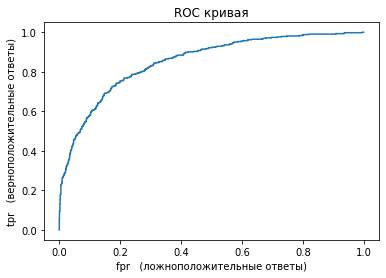

In [125]:
model = RandomForestClassifier(random_state = 12345, n_estimators = 27, max_depth = 8, class_weight = 'balanced')
model.fit(features_train, target_train)
predict_test = model.predict(features_test)

probablites_test = model.predict_proba(features_test)
probablites_test_one = probablites_test[:,1]
auc_roc = roc_auc_score(target_test,probablites_test_one)

fpr, tpr, threshold = roc_curve(target_test,probablites_test_one)
plt.figure()
plt.plot(fpr,tpr)
plt.xlabel('fpr   (ложноположительные ответы)')
plt.ylabel('tpr   (верноположительные ответы)')
plt.title('ROC кривая')

print('Значение метрики f1 для тестовой выборки:', f1_score(target_test,predict_test))
print('Значение метрики auc-roc для тестовой выборки:',auc_roc)

>Вывод: обученная модель обладает необходимым по заданию проекта качеством (f1 мера больше 0.59)

# 4. Общий вывод

Приведение балансировки признаков (был исползован upsamling и StandardScaler совместно с class_weight = 'balanced') позволяет значительно поднять качество моделей<br>
Например, метрики f1 моделей с одинаковыми параметрами было/стало:<br>
0.083 / 0.479<br>
0.540 / 0.596<br>
0.575 / 0.635<br>